# GRAD-CAM

### Essential libraries

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

### VGG16 model and preprocessing

In [1]:
# Load VGG16 model pretrained on ImageNet
model = models.vgg16(pretrained=True)
model.eval()

# Define preprocessing function
preprocess = transforms.Compose([
   transforms.Resize((224, 224)),
   transforms.ToTensor(),
   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:13<00:00, 42.4MB/s]


### Function to apply Grad-CAM

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook 

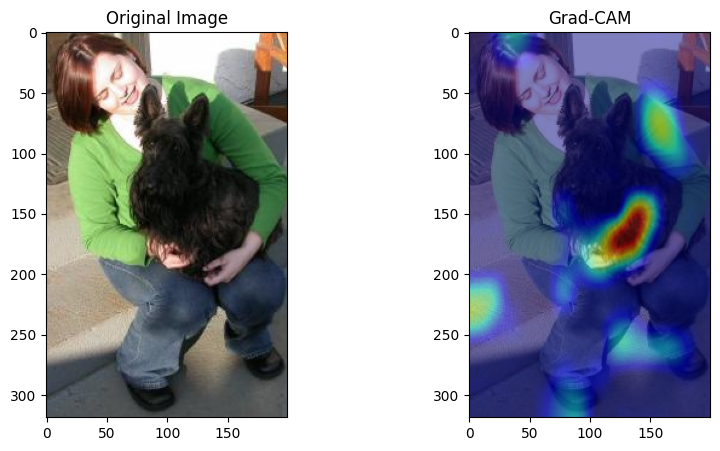

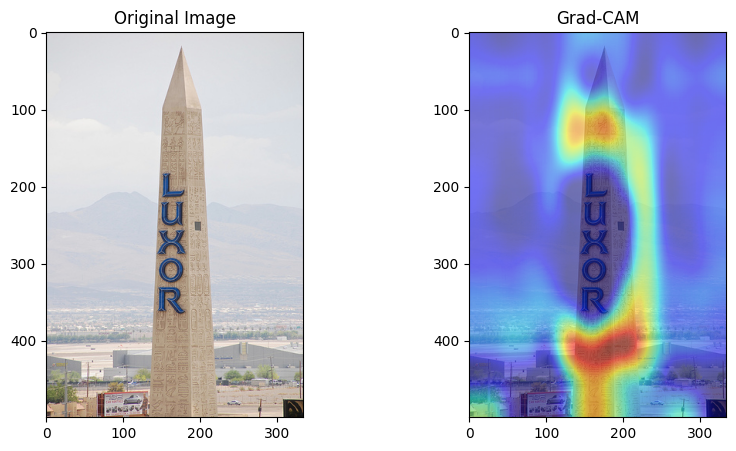

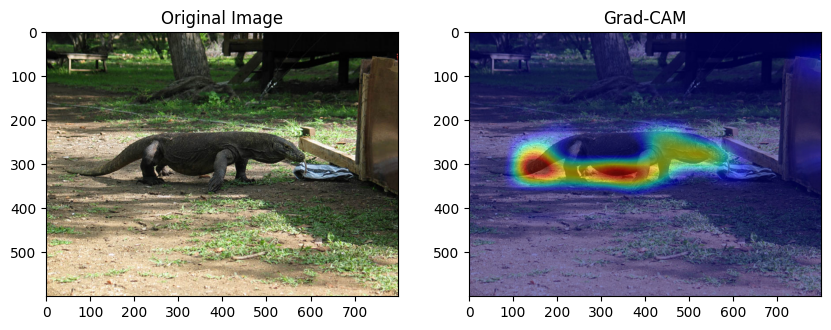

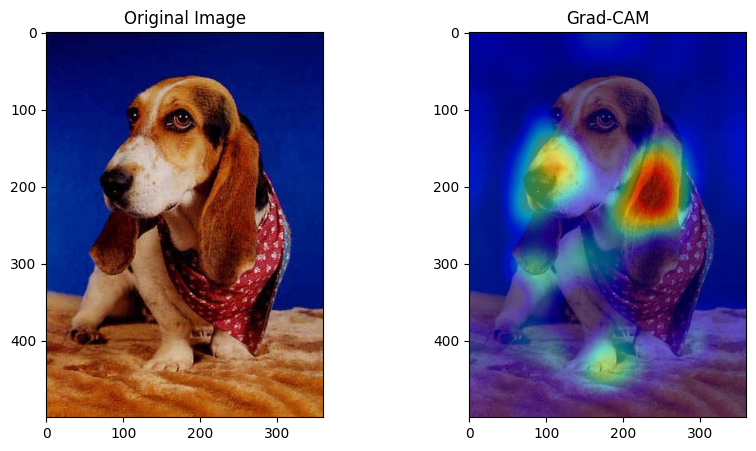

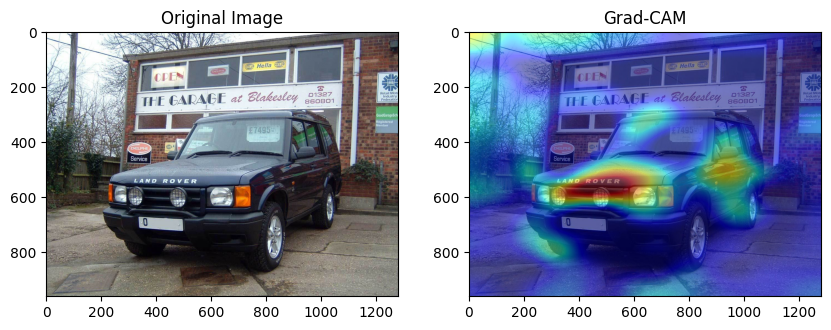

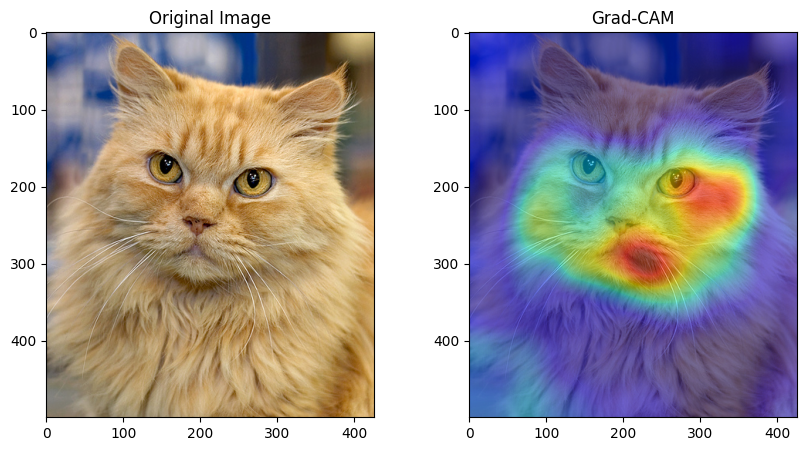

In [13]:
def grad_cam(model, image, target_layer, target_class):
    model.eval()
    features = []
    gradients = []

    def forward_hook(module, input, output):
        features.append(output)

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    # Register hooks to the target layer
    handle_forward = target_layer.register_forward_hook(forward_hook)
    handle_backward = target_layer.register_backward_hook(backward_hook)

    # Image preprocessing and forward pass
    tensor = preprocess(image).unsqueeze(0)
    tensor.requires_grad = True
    output = model(tensor)

    target = output[0][target_class]

    model.zero_grad()
    target.backward()

    # Remove hooks
    handle_forward.remove()
    handle_backward.remove()

    # Get the gradients and feature map
    gradients = gradients[0].cpu().data.numpy()[0]
    feature_map = features[0].cpu().data.numpy()[0]

    # Pool the gradients across the width and height dimensions
    pooled_gradients = np.mean(gradients, axis=(1, 2))

    # Weight the feature map with the pooled gradients
    for i in range(pooled_gradients.shape[0]):
        feature_map[i, ...] *= pooled_gradients[i]

    # Generate the CAM
    cam = np.mean(feature_map, axis=0)
    cam = np.maximum(cam, 0)  # Apply ReLU
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)
    cam = np.uint8(255 * cam)

    # Resize the CAM to the size of the input image
    cam = Image.fromarray(cam).resize(image.size, Image.ANTIALIAS)
    cam = np.array(cam)

    return cam

# Function to display image and Grad-CAM
def display_grad_cam(image_path, target_class, target_layer):
    image = Image.open(image_path).convert('RGB')
    cam = grad_cam(model, image, target_layer, target_class)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(image)
    plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.title('Grad-CAM')
    plt.show()

image_paths = [
    '/content/n02097298_Scotch_terrier.JPEG',
    '/content/n03837869_obelisk.JPEG',
    '/content/n01695060_Komodo_dragon.JPEG',
    '/content/n02088238_basset.JPEG',
    '/content/n03594945_jeep.JPEG',
    '/content/n02123394_Persian_cat.JPEG'
]
target_classes = [
    109,  # Scotch_terrier (dog)
    538,  # obelisk
    473,  #Komodo dragon
    161,  #basset
    609,  # jeep
    283,  #Persian_cat

]

target_layer = model.features[29]

# Generate and display Grad-CAM for each image
for image_path, target_class in zip(image_paths, target_classes):
    display_grad_cam(image_path, target_class, target_layer)
